# Preparing Environment

In [1]:
import datetime as dt
import itertools
import os
from dataclasses import dataclass
from pathlib import Path

import colorcet as cc
import git
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import pyodbc
import requests
import seaborn as sns; sns.set_theme(style='white')
import shapely
import sklearn.tree

from shapely.geometry import Point
from sqlalchemy import create_engine
from tqdm.notebook import tqdm

REPO_ROOT = Path(git.Repo('.', search_parent_directories=True).working_tree_dir).absolute()
OCCUPANCY_FEATHER_PATH = REPO_ROOT / 'data' / 'raw' / 'parking_zone_occupancy_aggr.feather'

%cd -q $REPO_ROOT

import app.constants
import app.keeper_of_the_state

# Loading Occupancy Data

In [32]:
if OCCUPANCY_FEATHER_PATH.exists():
    occupancy = pd.read_feather(OCCUPANCY_FEATHER_PATH)
else:
    occupancy = pd.read_sql_query(
        r'''
            SELECT *
            FROM [dbo].[parking_zone_occupancy_aggr]
            ORDER BY zone_name, semihour
        ''',
        'mssql+pyodbc://{user}:{password}@{server_url}:{server_port}/{database}?driver={driver}'.format(
            user='padmin',
            password=os.getenv('SQL_SERVER_PASSWORD'),
            server_url='localhost',
            server_port='1433',
            database='parking_prediction',
            driver='ODBC+Driver+17+for+SQL+Server'
        )
    )
    occupancy.to_feather(OCCUPANCY_FEATHER_PATH)

occupancy = occupancy.assign(
    available_rate=lambda df: 1 - df.occu_cnt_rate,
    dayofweek=lambda df: df.semihour.dt.dayofweek.astype('category'),
    semihour_tuples=lambda df: pd.Series(
        zip(df.semihour.dt.hour, df.semihour.dt.minute),
        dtype='category', index=df.index
    )
)

In [33]:
occupancy.info(null_counts=True, memory_usage='deep')
occupancy.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16006949 entries, 0 to 16006948
Data columns (total 17 columns):
 #   Column                Non-Null Count     Dtype         
---  ------                --------------     -----         
 0   zocc_id               16006949 non-null  int64         
 1   zone_name             16006949 non-null  object        
 2   semihour              16006949 non-null  datetime64[ns]
 3   occu_min              16006949 non-null  float64       
 4   occu_mtr_cnt          16006949 non-null  int64         
 5   no_trxn_one_day_flg   16006949 non-null  int64         
 6   no_trxn_one_week_flg  16006949 non-null  int64         
 7   load_on               16006949 non-null  datetime64[ns]
 8   total_cnt             16006949 non-null  int64         
 9   occu_min_rate         16006949 non-null  float64       
 10  occu_cnt_rate         16006949 non-null  float64       
 11  city_holiday          389424 non-null    object        
 12  shortnorth_event      0 no

,0,1,2,3,4
zocc_id,15894489,15894490,15894491,15894492,15894493
zone_name,17002,17002,17002,17002,17002
semihour,2018-08-27 00:00:00,2018-08-27 00:30:00,2018-08-27 01:00:00,2018-08-27 01:30:00,2018-08-27 02:00:00
occu_min,0,0,0,0,0
occu_mtr_cnt,0,0,0,0,0
no_trxn_one_day_flg,0,0,0,0,0
no_trxn_one_week_flg,0,0,0,0,0
load_on,2020-09-15 05:23:00.367000,2020-09-15 05:23:00.367000,2020-09-15 05:23:00.367000,2020-09-15 05:23:00.367000,2020-09-15 05:23:00.367000
total_cnt,1,1,1,1,1
occu_min_rate,0,0,0,0,0


# Loading Meter Data

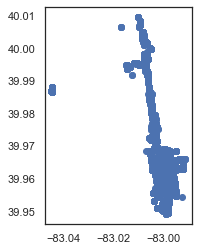

In [170]:
meters = pd.DataFrame.from_records(
    [
        (zone_id, float(longitude), float(latitude))
        for latitude, longitude, zone_id in map(
            lambda meter: meter.split(','),
            requests.post(
                'https://data.smartcolumbusos.com/api/v1/query?_format=csv',
                data=(
                    'SELECT latitude, longitude, "pm zone number" AS zone '
                    'FROM city_of_columbus__columbus_parking_meters'
                )
            ).text.strip().split('\n')[1:]
        )
        if longitude and latitude and len(zone_id) > 4
    ],
    columns=['zone_id', 'longitude', 'latitude']
).assign(
    longitude=lambda df: df.longitude.where(
        df.longitude.between(-85, -82),
        -df.longitude
    ),
    latitude=lambda df: df.latitude.where(
        df.latitude.between(38, 41),
        -df.latitude
    ),
    geometry=lambda df: [Point(longlat) for longlat in zip(df.longitude, df.latitude)],
    valid_longlat=lambda df: df.geometry.map(lambda geom: (-85 < geom.x < -82) & (38 < geom.y < 41))
).pipe(lambda df: gpd.GeoDataFrame(df, crs='epsg:4326'))

meters.plot();

# Loading Columbus Road Network

In [312]:
ox.config(cache_folder='.cache', use_cache=True, all_oneway=True)

west, south, east, north = meters.geometry.unary_union.bounds
long_buffer = .05 * (east - west)
lat_buffer = .05 * (north - south)

C = ox.graph_from_bbox(
    north + lat_buffer, south - lat_buffer,
    east + long_buffer, west - long_buffer,
    simplify=False
)

# Spatio-Temporal Auto-Correlation

## Compute Distances Between Zone Meters

### Create Node & Edge GDFs from Columbus Graph

In [469]:
nodes_gdf, edges_gdf = ox.graph_to_gdfs(C)

### Insert Meter Nodes into Nodes GDF

In [458]:
meters = meters.drop_duplicates()
nodes_gdf_updated = pd.concat([
    nodes_gdf,
    meters.rename({'longitude': 'x', 'latitude': 'y'}, axis='columns') # meters.rename({'longitude': 'x', 'latitude': 'y'}, axis='columns')
])
nodes_gdf_updated

,y,x,osmid,highway,ref,geometry,zone_id,valid_longlat
3958571008,39.995903,-83.019381,3.958571e+09,NaN,NaN,POINT (-83.01938 39.99590),NaN,NaN
3958571013,39.995978,-83.019396,3.958571e+09,NaN,NaN,POINT (-83.01940 39.99598),NaN,NaN
3958571014,39.995983,-83.019348,3.958571e+09,NaN,NaN,POINT (-83.01935 39.99598),NaN,NaN
3958571019,39.996004,-83.019134,3.958571e+09,NaN,NaN,POINT (-83.01913 39.99600),NaN,NaN
3958571021,39.996040,-83.019359,3.958571e+09,crossing,NaN,POINT (-83.01936 39.99604),NaN,NaN
...,...,...,...,...,...,...,...,...
2535,40.001547,-83.006553,NaN,NaN,NaN,POINT (-83.00655 40.00155),72056,True
2543,40.004108,-83.008103,NaN,NaN,NaN,POINT (-83.00810 40.00411),72057,True
2555,40.004044,-83.008417,NaN,NaN,NaN,POINT (-83.00842 40.00404),72058,True
2561,40.004014,-83.007768,NaN,NaN,NaN,POINT (-83.00777 40.00401),72059,True


### Calculate Nearest Edges to Meters

In [459]:
meters_nearest_edge_keys = ox.get_nearest_edges(C, meters.geometry.x, meters.geometry.y, method='balltree')

meters_nearest_edge_records = [
    edges_gdf[(edges_gdf[['u', 'v', 'key']] == edge_key).all(axis='columns')].iloc[0]
    for edge_key in meters_nearest_edge_keys
]

meters_nearest_edges = [record.geometry for record in meters_nearest_edge_records]
meters_nearest_edge_indices = [record.name for record in meters_nearest_edge_records]

### Map $(A, B) \longrightarrow (A, M), (M, B)$ Edges for Each Nearest Edge $(A, B)$ to Meter $M$

In [460]:
meters_projected = [
    nearest_edge.interpolate(nearest_edge.project(meter.geometry))
    for (_, meter), nearest_edge in zip(meters.iterrows(), meters_nearest_edges)
]

meters_projected_on_nearest_edges = [
    shapely.ops.snap(nearest_edge, projected_meter, 0.0000)
    for nearest_edge, projected_meter in zip(meters_nearest_edges, meters_projected)
]

print(max(edge.distance(meter)
          for meter, edge in zip(meters_projected, meters_projected_on_nearest_edges)))
assert all(
    edge.distance(meter) < 1e-12
    for meter, edge in zip(meters_projected, meters_projected_on_nearest_edges)
)

meters_projected_splits = [
    [
        shapely.geometry.LineString([start, end])
        for start, end in zip(
            line_string.coords,
            list(line_string.coords)[1:]
        )
    ]
    for line_string in meters_projected_on_nearest_edges
]

7.505092422398604e-15


In [461]:
assert all(shapely.ops.linemerge(parts) == original
           for parts, original in zip(meters_projected_splits, meters_projected_on_nearest_edges))

### Insert Projected Meter Nodes into Nodes GDF

In [462]:
meters_projected_gdf = meters.assign(
    geometry=meters_projected,
    longitude=lambda gdf: gdf.geometry.x,
    latitude=lambda gdf: gdf.geometry.y
).rename(
    {'longitude': 'x', 'latitude': 'y'}, axis='columns'
).drop_duplicates()

nodes_gdf_updated = pd.concat([nodes_gdf, meters_projected_gdf])
display(nodes_gdf_updated.tail())

list(map(lambda ls: list(map(str, ls)), meters_projected_splits))[-5:]

,y,x,osmid,highway,ref,geometry,zone_id,valid_longlat
2535,40.001590,-83.006550,NaN,NaN,NaN,POINT (-83.00655 40.00159),72056,True
2543,40.004137,-83.008102,NaN,NaN,NaN,POINT (-83.00810 40.00414),72057,True
2555,40.004019,-83.008418,NaN,NaN,NaN,POINT (-83.00842 40.00402),72058,True
2561,40.003990,-83.007769,NaN,NaN,NaN,POINT (-83.00777 40.00399),72059,True
2564,39.991725,-83.012390,NaN,NaN,NaN,POINT (-83.01239 39.99173),72060,True


[['LINESTRING (-83.0065496 40.0015901, -83.0065093 40.0016931)',
  'LINESTRING (-83.0065093 40.0016931, -83.0064745 40.0017816)',
  'LINESTRING (-83.0064745 40.0017816, -83.00643599999999 40.0018786)',
  'LINESTRING (-83.00643599999999 40.0018786, -83.00640110000001 40.0019418)',
  'LINESTRING (-83.00640110000001 40.0019418, -83.00633139999999 40.0020514)'],
 ['LINESTRING (-83.007569 40.0041144, -83.0080347 40.004135)',
  'LINESTRING (-83.0080347 40.004135, -83.0086194 40.0041553)'],
 ['LINESTRING (-83.00866000000001 40.004029, -83.00805149999999 40.0040044)'],
 ['LINESTRING (-83.00758190000001 40.0039811, -83.00805149999999 40.0040044)'],
 ['LINESTRING (-83.0123651 39.9920977, -83.0123973 39.9916149)']]

### Replace Edges in `edge_gdf` with New Records, Updating Lengths

In [463]:
edges_gdf_copy = edges_gdf.copy()

In [464]:
def anchor_to_point(edges, point, tolerance=1e-15):
    if len(edges) < 1:
        print('uh oh')
    anchored_edges = []
    for edge in edges:
        boundary = list(edge.boundary)
        boundary_distances = [boundary_point.distance(point)
                              for boundary_point in boundary]
        boundary_points_nearby = sum(distance < tolerance for distance in boundary_distances)
        if boundary_points_nearby == 0:
            raise ValueError(f'Boundary of {edge} more than {tolerance} units from {point}.')
#         elif boundary_points_nearby > 1:
#             raise ValueError(f'Multiple points on the boundary of {edge} are within {tolerance} units of {point}.')
        elif boundary_points_nearby >= 1:
            index_nearest_boundary_point = np.argmin(boundary_distances)
            updated_boundary = boundary
            updated_boundary[index_nearest_boundary_point] = point
            anchored_edges.append(shapely.geometry.LineString(updated_boundary))
        else:
            raise Exception
    return anchored_edges


def update_node_and_edge_geometry(nodes_gdf, edges_gdf, edge_idx, new_edge_geom):
    u_new, v_new = list(new_edge_geom.boundary)
    u_key, v_key = edges_gdf.loc[edge_idx, ['u', 'v']]
#     nodes_gdf.loc[[u_key, v_key], 'geometry'] = list(new_edge_geom.boundary)
    nodes_gdf.loc[u_key, 'geometry'] = u_new
    nodes_gdf.loc[v_key, 'geometry'] = v_new
    edges_gdf.loc[edge_idx, 'geometry'] = new_edge_geom
    return nodes_gdf, edges_gdf


def replace_edge_record(edges_gdf, node_idx, edge_idx, edge_splits):
    old_edge_record = edges_gdf.loc[edge_idx]
    old_edge = old_edge_record.geometry
    new_edge1, new_edge2 = edge_splits
    new_node = list(new_edge1.boundary)[0]

    new_record1, new_record2 = old_edge_record.copy(), old_edge_record.copy()

    new_record1.geometry, new_record2.geometry = new_edge1, new_edge2
    new_record1.v = new_record2.u = node_idx
    new_record1.length, new_record2.length = (
        old_edge_record.length * (edge.length / old_edge.length)
        for edge in edge_splits
    )
    old_name = old_edge_record.name
    new_record1.name, new_record2.name = f'{old_name}_1', f'{old_name}_2'
    edges_gdf = edges_gdf.drop(index=old_name)
    edges_gdf.loc[new_record1.name] = new_record1
    edges_gdf.loc[new_record2.name] = new_record2
    return edges_gdf

In [465]:
for idx, ((meter_index, meter_projected), (original_edge_index, original_edge_data), edge_splits) in enumerate(
    tqdm(zip(
        meters_projected_gdf.iterrows(),
        edges_gdf.loc[meters_nearest_edge_indices].iterrows(),
        meters_projected_splits
))):
    edge_splits_anchored = anchor_to_point(edge_splits, meter_projected.geometry, tolerance=1e-3)

    if len(edge_splits_anchored) == 1:
        edge_snapped = edge_splits_anchored[0]
        nodes_gdf_updated, edges_gdf_copy = update_node_and_edge_geometry(
            nodes_gdf_updated, edges_gdf_copy,
            original_edge_index, edge_snapped
        )
    elif len(edge_splits_anchored) == 2:
        edges_gdf_copy = replace_edge_record(
            edges_gdf_copy,
            meter_index,
            original_edge_index,
            edge_splits_anchored
        )
    else:
        raise ValueError(f'Every edge split must consist of one or two linear LineStrings. The {idx + 1}-th edge contained {len(edge_splits_anchored)} line segments.')

ValueError: Every edge split must consist of one or two linear LineStrings. The 15-th edge contained 3 line segments.

In [467]:
list(map(str, meters_projected_splits[14]))

['LINESTRING (-83.0015106 39.9675311, -83.00147560000001 39.9675527)',
 'LINESTRING (-83.00147560000001 39.9675527, -83.0008064 39.9676226)',
 'LINESTRING (-83.0008064 39.9676226, -83.00076439999999 39.9676273)']

In [470]:
C_updated = ox.graph_from_gdfs(nodes_gdf_updated.iloc[:-430], edges_gdf_copy)

In [472]:
len(C.nodes), len(C_updated.nodes)

(41435, 17748)

## Take 2: Using OSMnx on Largest Strongly Connected Component

## Calculate Distance Matrix

In [313]:
C_stronk = ox.utils_graph.get_largest_component(C, strongly=True)

In [316]:
# meters_deduped = meters.drop_duplicates()
meters_deduped = pd.read_pickle('meters_deduped.pkl')
meters_deduped = pd.merge(
    meters_deduped,
    meters_deduped.groupby('zone_id')
                  .geometry
                  .unique()
                  .map(lambda points: shapely.geometry.MultiPoint(points))
                  .rename('zone_geometry'),
    on='zone_id',
    how='left'
).assign(
    zone_centroid=lambda df: df.zone_geometry.map(lambda geom: geom.centroid)
)

In [317]:
meters_deduped_gdf = gpd.GeoDataFrame(
    meters_deduped.drop(columns='geometry'),
    geometry='zone_centroid',
    crs='epsg:4326'
)

In [318]:
nearest_nodes_og = ox.get_nearest_nodes(C_stronk, meters_deduped.longitude, meters_deduped.latitude)
central_nodes = ox.get_nearest_nodes(C_stronk, meters_deduped_gdf.geometry.x, meters_deduped_gdf.geometry.y)

In [ ]:
og_source_target_iter = tqdm(list(itertools.product(nearest_nodes_og, repeat=2)))

og_shortest_paths = [nx.shortest_path(C_stronk, source, target, weight='length')
                     for source, target in og_source_target_iter]

In [ ]:
central_source_target_iter = tqdm(list(itertools.product(central_nodes, repeat=2)))

In [242]:
for (meter_idx, node) in zip(meters_deduped_gdf.index, central_nodes):
    C_stronk.nodes[node]['parking_zone'] = meters_deduped_gdf.iloc[meter_idx]['zone_id']

### Here be Dragons

In [243]:
Z = C_stronk.copy()

In [258]:
Z.edges[5395447943, 5395447944, 0]
Z.edges[5395447944, 5395447943, 0]

{'osmid': 559401232, 'highway': 'footway', 'oneway': False, 'length': 29.299}

In [250]:
unwanted_highway = {
    'cycleway',
    'footway',
    'path',
    'pedestrian',
    'steps'
}

In [247]:
Z.edges(5395447943, keys=True, data=True)

OutMultiEdgeDataView([(5395447943, 5395447944, 0, {'osmid': 559401232, 'highway': 'footway', 'oneway': False, 'length': 29.299}), (5395447943, 5395447961, 0, {'osmid': 559401236, 'highway': 'footway', 'oneway': False, 'length': 91.079}), (5395447943, 5395447975, 0, {'osmid': 777678063, 'highway': 'footway', 'oneway': False, 'length': 35.54})])

In [288]:
twoways = [edge for edge in C_stronk.edges(keys=True, data=True)
           if not edge[-1]['oneway']]

In [310]:
for source, target, key, data in twoways:
    assert C_stronk.has_edge(target, source)
    print(C_stronk[source][target])
    print(C_stronk[target][source])
    reversed_edge_osmid = C_stronk.get_edge_data(target, source, 'osmid')
    assert reversed_edge_osmid is not None
    assert reversed_edge_osmid != data['osmid']

{0: {'osmid': 599895949, 'highway': 'service', 'oneway': False, 'length': 7.157}}
{0: {'osmid': 599895949, 'highway': 'service', 'oneway': False, 'length': 7.157}}


AssertionError: 

In [273]:
def tuplize(maybe_tuple, value):
    if isinstance(maybe_tuple, tuple):
        return maybe_tuple + (value,)
    else:
        return (maybe_tuple, value)


remaining_nodes = [node for node in central_nodes]

for node in tqdm(remaining_nodes):
    uv_edges_to_remove = []
    uw_edges_to_add = []
    for u, v, uv_key, uv_data in Z.edges(node, keys=True, data=True):
        if v in central_nodes:
            continue
        # Create a new edge from centroid to each neighbor_of_neighbor
        # and delete the edges
        vw_edges_to_remove = []
        most_recent_uw_key = {}
        for v, w, vw_key, vw_data in Z.edges(v, keys=True, data=True):
            vw_edges_to_remove.append((v, w, vw_key))
            if uv_data['highway'] in unwanted_highway or vw_data['highway'] in unwanted_highway:
                continue

            if w in most_recent_uw_key:
                most_recent_uw_key[w] = most_recent_uw_key[w] + 1
            else:
                most_recent_uw_key[w] = Z.new_edge_key(u, w)

            uw_edges_to_add.append(
                (
                    u, w,
                    most_recent_uw_key[w],
                    dict(
                        length=uv_data['length'] + vw_data['length'],
                        highway=tuplize(uv_data['highway'], vw_data['highway']),
                        osmid=tuplize(uv_data['osmid'], vw_data['osmid']),
                        oneway=tuplize(uv_data['oneway'], vw_data['oneway'])
                    )
                )
            )
        for v, w, vw_key in vw_edges_to_remove:
            Z.remove_edge(v, w, vw_key)
            if w not in remaining_nodes:
                remaining_nodes.append(w)
        uv_edges_to_remove.append((u, v, uv_key))
    Z.add_edges_from(uw_edges_to_add)
    Z.remove_edges_from(uv_edges_to_remove)

In [279]:
Z_stronk = ox.utils_graph.get_largest_component(Z, strongly=True)

32

In [278]:
source_target_iter = tqdm(list(itertools.product(central_nodes, repeat=2)))

shortest_paths = [nx.shortest_path(Z, source, target, weight='length')
                  for source, target in source_target_iter]
# :
#     shortest_paths.append()
#                   for source, target in ]
#     nx.shortest_path_length()

NetworkXNoPath: No path to 4917368020.

In [492]:
import pickle
with open('shortest_paths.pkl', 'wb+') as f:
    pickle.dump(shortest_paths, f)

In [10]:
import pickle
with open('shortest_paths.pkl', 'rb') as f:
    shortest_paths = pickle.load(f)

# assert all(path == path_reloaded for path, path_reloaded in zip(shortest_paths, shortest_paths_reloaded))

In [172]:
# meters_deduped.to_pickle('meters_deduped.pkl')

meters_deduped = pd.read_pickle('meters_deduped.pkl')

In [59]:
unique_meter_locations = len(meters_deduped)

assert len(shortest_paths) // unique_meter_locations == unique_meter_locations

distance_matrix = [
    shortest_paths[unique_meter_locations * i:unique_meter_locations * (i + 1)]
    for i in range(len(shortest_paths) // unique_meter_locations)
]

In [27]:
occupancy[(occupancy.zone_name == '72047') & (occupancy.semihour.dt.hour == 13)].av
# occupancy[occupancy.total_cnt > 10].zone_name.unique()

,zocc_id,zone_name,semihour,occu_min,occu_mtr_cnt,no_trxn_one_day_flg,no_trxn_one_week_flg,load_on,total_cnt,occu_min_rate,occu_cnt_rate,city_holiday,shortnorth_event,no_data
15482157,15369697,72047,2018-08-27 13:00:00,0.0,0,1,1,2020-09-15 05:21:43.250,20,0.0,0.0,None,None,1
15482158,15369698,72047,2018-08-27 13:30:00,0.0,0,1,1,2020-09-15 05:21:43.250,20,0.0,0.0,None,None,1
15482205,15369745,72047,2018-08-28 13:00:00,0.0,0,1,1,2020-09-15 05:21:43.250,20,0.0,0.0,None,None,1
15482206,15369746,72047,2018-08-28 13:30:00,0.0,0,1,1,2020-09-15 05:21:43.250,20,0.0,0.0,None,None,1
15482253,15369793,72047,2018-08-29 13:00:00,0.0,0,1,1,2020-09-15 05:21:43.250,20,0.0,0.0,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15519502,15407042,72047,2020-10-13 13:30:00,0.0,0,1,1,2020-09-15 05:21:43.250,20,0.0,0.0,None,None,1
15519549,15407089,72047,2020-10-14 13:00:00,0.0,0,1,1,2020-09-15 05:21:43.250,20,0.0,0.0,None,None,1
15519550,15407090,72047,2020-10-14 13:30:00,0.0,0,1,1,2020-09-15 05:21:43.250,20,0.0,0.0,None,None,1
15519597,15407137,72047,2020-10-15 13:00:00,0.0,0,1,1,2020-09-15 05:21:43.250,20,0.0,0.0,None,None,1


### Create NetworkX DiGraph from `distance_matrix` Adjacency Matrix

In [67]:
meter_idx = meters_deduped.index

In [75]:
adjacency_dicts = dict(zip(meter_idx, list(map(lambda row: dict(zip(meter_idx, row)), distance_matrix))))
for meter in meter_idx:
    del adjacency_dicts[meter][meter]

In [79]:
#M = nx.DiGraph(adjacency_dicts)

In [84]:
M = C_stronk.subgraph(nearest_nodes_og)

### TODO:
- Decide on how to define "neighbors".

In [94]:
from sklearn.neighbors import radius_neighbors_graph, kneighbors_graph

In [92]:
len(M.nodes), len(M.edges)

nearest_to_original = dict(zip(nearest_nodes_og, meter_idx))

neighbors = 
lps.weights.W()
M.neighbors()

<bound method DiGraph.successors of <networkx.classes.multidigraph.MultiDiGraph object at 0x1b32b4340>>

## Create Neighbors Graph from Constrained Delaunay Triangulation

In [394]:
import triangle

Fifteen zones have shared centroids … resulting in non-planar graphs

In [429]:
meters_deduped.zone_centroid.map(lambda point: (point.x, point.y)).value_counts().value_counts()

1    399
2     14
3      1
Name: zone_centroid, dtype: int64

In [438]:
zones_deduped = meters_deduped.groupby(meters_deduped.zone_centroid.map(lambda point: (point.x, point.y))).zone_id.unique().reset_index()

In [448]:
vertices = {'vertices': np.array(zones_deduped.zone_centroid.map(list).tolist())}
delaunay2 = triangle.triangulate(
    vertices,
    'q20 n e'
)

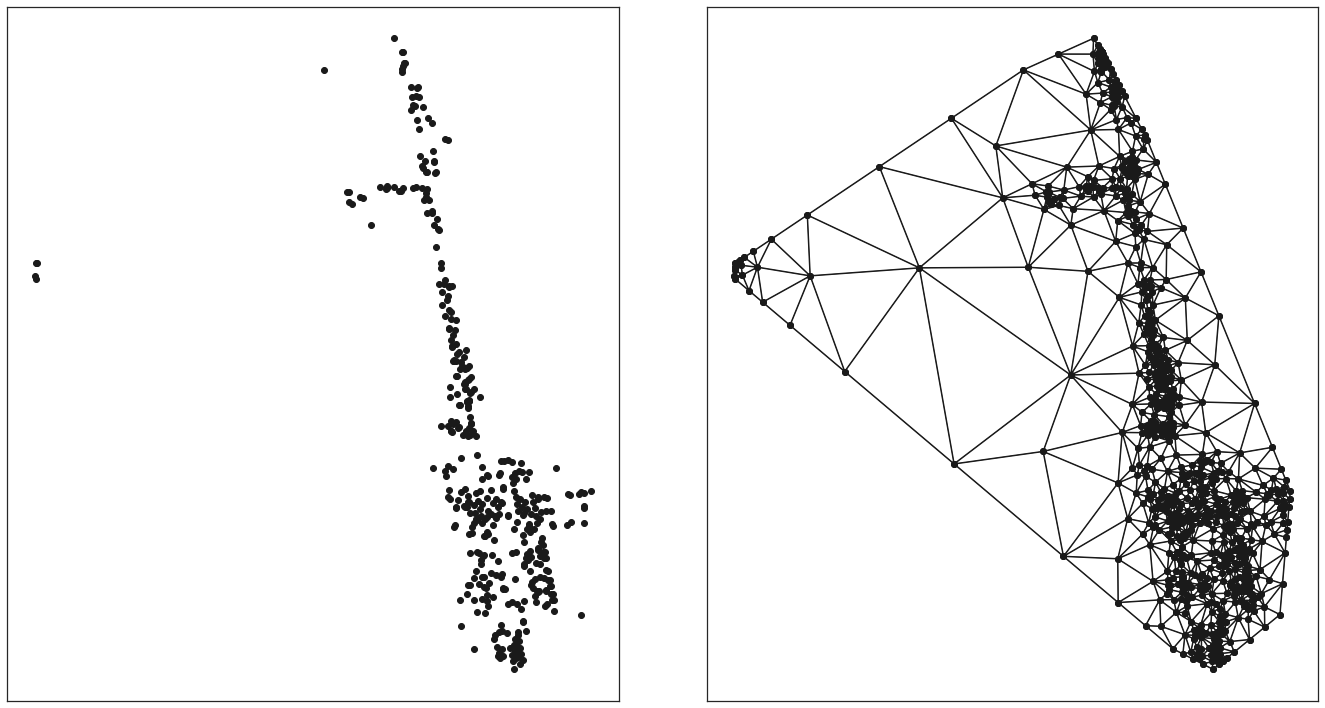

In [449]:
# fig, ax = plt.subplots(1, 1, figsize=(20, 20))
# triangle.plot(ax, delaunay2)

triangle.compare(plt, vertices, delaunay2, figsize=(20, 10))

In [476]:
delaunay2

{'vertices': array([[-83.044665  ,  39.986808  ],
        [-83.044573  ,  39.986538  ],
        [-83.044573  ,  39.988045  ],
        ...,
        [-83.0149997 ,  39.96997888],
        [-83.01954781,  39.99932733],
        [-83.02688972,  39.98761627]]),
 'vertex_markers': array([[1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],

In [475]:
# delaunay2['vertex_markers'][].shape
(delaunay2['vertex_markers'] == 0).all(axis=(-1)).sum()

773

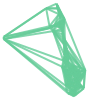

In [326]:
delaunay = shapely.ops.triangulate(meters_deduped_gdf.geometry.unary_union, edges=True)
shapely.ops.unary_union(delaunay)

In [348]:
list(map(lambda pt: list(pt.coords), delaunay))
list(delaunay[0].boundary)

# nx.DiGraph([map()])
delaunay_edges = [tuple(edge.boundary) for edge in delaunay]

In [370]:
METERS_PER_MILE = 1609.344
MAX_NEIGHBOR_EDGE_LENGTH = METERS_PER_MILE

delaunay_edge_meter_indices = [
    tuple(
        meters_deduped[meters_deduped.zone_centroid == point].index[0]
        for point in boundary
    )
    for boundary in tqdm(delaunay_edges)
]

delaunay_edge_central_nodes = [
    (central_nodes[source], central_nodes[target], {'length': distance_matrix[source][target]})
    for source, target in tqdm(delaunay_edge_meter_indices)
    if distance_matrix[source][target] < MAX_NEIGHBOR_EDGE_LENGTH
] + [
    (central_nodes[target], central_nodes[source], {'length': distance_matrix[target][source]})
    for source, target in tqdm(delaunay_edge_meter_indices)
    if distance_matrix[target][source] < MAX_NEIGHBOR_EDGE_LENGTH
]

NetworkXException: G is not planar.

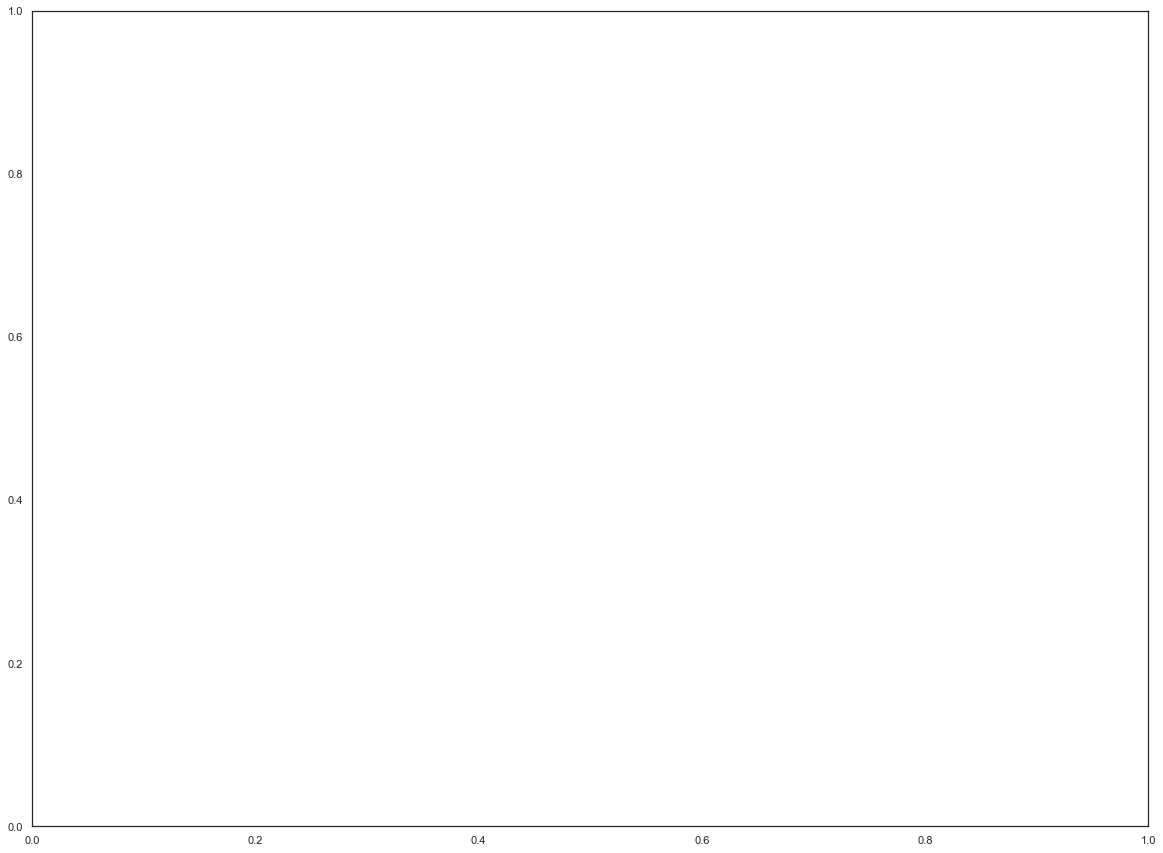

In [388]:
ZN = nx.DiGraph(delaunay_edge_central_nodes, crs='epsg:4326')

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
nx.draw_planar(ZN, ax=ax, arrows=False, node_size=2, with_labels=False)

## Compute Moran's I per TOD & DOW

In [36]:
import esda
import libpysal as lps

In [54]:
means_by_zone_and_semihour = (occupancy.set_index('semihour')
                                       .between_time('08:00', '22:00', include_end=False)
                                       .reset_index()
                                       .loc[lambda df: df.semihour < '2019-12-31']
                                       .assign(
                                           semihour_tod=lambda df: pd.Series(
                                               list(
                                                   zip(
                                                       df.semihour.dt.hour,
                                                       df.semihour.dt.minute
                                                   )
                                               ),
                                               name='semihour'
                                           )
                                       )
                                       .groupby(['zone_name', 'semihour_tod'])
                                       .available_rate.mean())

In [56]:
semihour_means_by_zone = means_by_zone_and_semihour.unstack()

In [57]:
semihour_means_by_zone

semihour_tod,"(8, 0)","(8, 30)","(9, 0)","(9, 30)","(10, 0)","(10, 30)","(11, 0)","(11, 30)","(12, 0)","(12, 30)",...,"(17, 0)","(17, 30)","(18, 0)","(18, 30)","(19, 0)","(19, 30)","(20, 0)","(20, 30)","(21, 0)","(21, 30)"
zone_name,,,,,,,,,,,,,,,,,,,,,
17002,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
17003,0.997963,0.997963,0.993890,0.995927,0.997963,0.997963,0.997963,1.000000,0.995927,0.993890,...,0.989817,0.991853,0.995927,0.995927,0.995927,0.995927,0.997963,0.995927,0.995927,0.995927
17012,0.995054,0.988071,0.547570,0.472505,0.437591,0.407332,0.409659,0.443410,0.424789,0.431190,...,0.603142,0.662205,0.697702,0.764038,0.805354,0.836485,0.876055,0.898749,0.927844,0.945010
17013,0.996369,0.994864,0.904631,0.804038,0.722306,0.658461,0.625786,0.603206,0.572921,0.578854,...,0.888869,0.916143,0.935535,0.952537,0.965288,0.975560,0.980696,0.984681,0.985389,0.985478
17014,0.873727,0.728310,0.553157,0.423625,0.383299,0.354786,0.342159,0.339308,0.341344,0.340122,...,0.984521,0.985743,0.950305,0.940122,0.929532,0.923829,0.924236,0.942159,0.956415,0.969857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31027,0.880855,0.845214,0.798371,0.738289,0.670061,0.594705,0.521385,0.442974,0.392057,0.374745,...,0.361507,0.327902,0.310591,0.304481,0.299389,0.305499,0.313646,0.340122,0.358452,0.422607
31028,0.746640,0.645825,0.551120,0.490631,0.444603,0.398982,0.358248,0.331976,0.325866,0.321385,...,0.307332,0.304684,0.306925,0.304888,0.306721,0.312220,0.320774,0.336049,0.357026,0.400000
31029,0.760692,0.675153,0.605906,0.541752,0.504073,0.475560,0.455193,0.430754,0.415479,0.406314,...,0.420570,0.438900,0.511202,0.547862,0.566191,0.571283,0.584521,0.600815,0.627291,0.667006


In [191]:
meters_deduped = pd.read_pickle('meters_deduped.pkl')
meters_deduped = pd.merge(
    meters_deduped,
    meters_deduped.groupby('zone_id')
                  .geometry
                  .unique()
                  .map(lambda points: shapely.geometry.MultiPoint(points))
                  .rename('zone_geometry'),
    on='zone_id',
    how='left'
).assign(
    zone_centroid=lambda df: df.zone_geometry.map(lambda geom: geom.centroid)
)

In [218]:
C_stronk_simplified = C_stronk.copy()

In [212]:
from scipy.spatial import Voronoi, voronoi_plot_2d

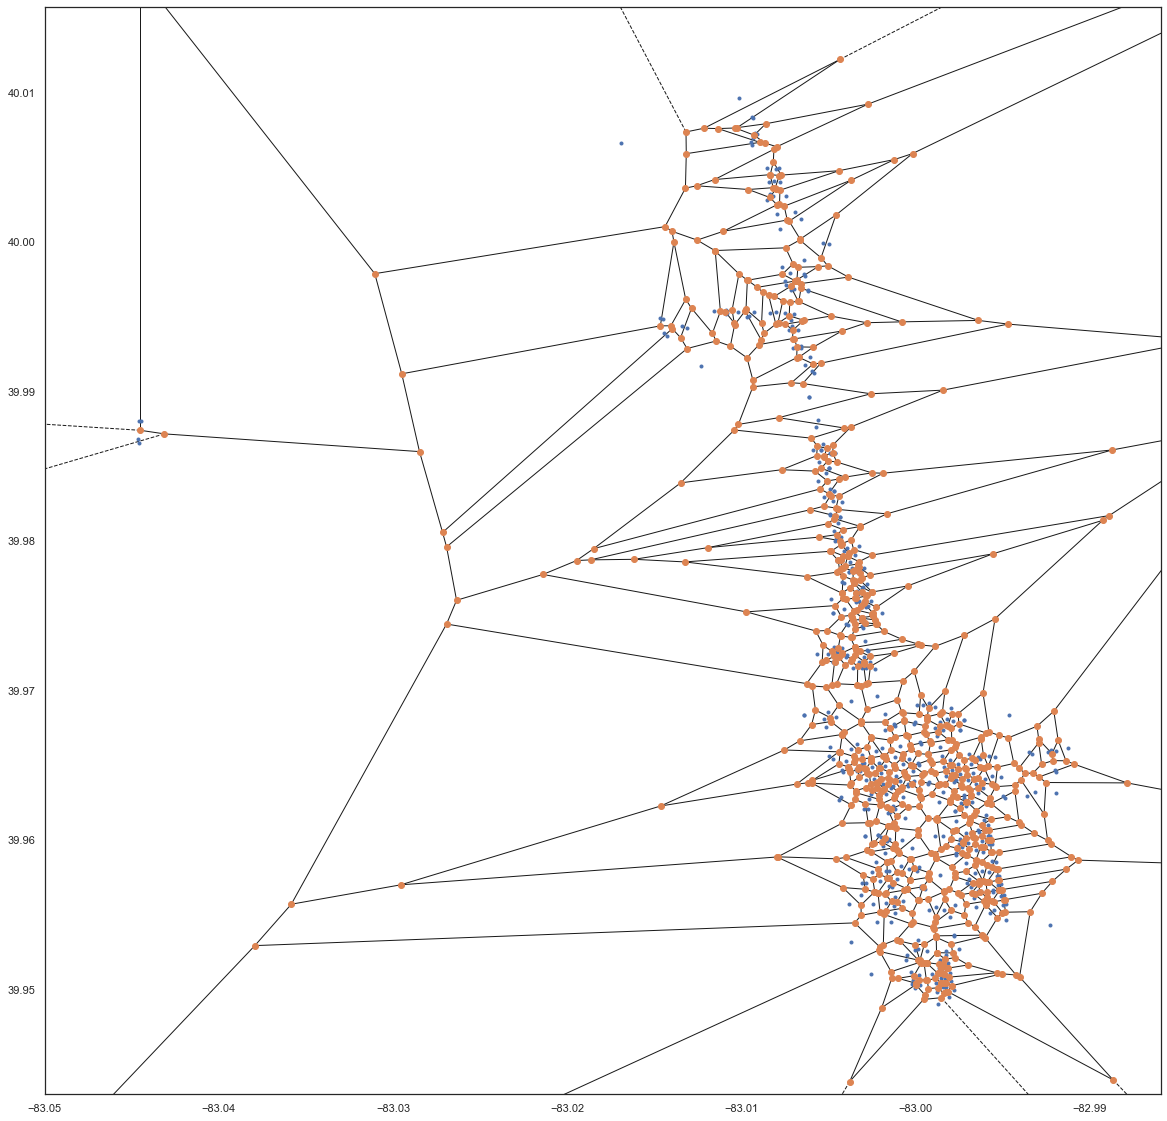

In [216]:
zones_voronoi = Voronoi(np.array(meters_deduped.zone_centroid.map(lambda geom: list(geom.coords[0])).to_list()))

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
voronoi_plot_2d(zones_voronoi, ax=ax);

In [211]:
zones_voronoi

In [ ]:
lps.weights.W

In [ ]:
esda.Moran()

<AxesSubplot:>

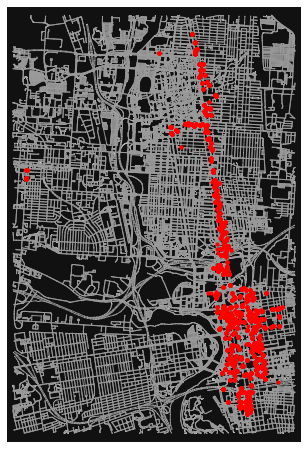

In [66]:
fig, ax = ox.plot_graph(C, node_size=1, node_zorder=0, edge_alpha=.9, show=False, close=False)
meters.plot(ax=ax, color='red', markersize=10, zorder=10)

# Random Forest Feature Selection

In [130]:
error = occupancy.occu_min_rate - (occupancy.occu_min / (occupancy.total_cnt * 30)).clip(0, 1)
occupancy[error >= 1e-6]

,zocc_id,zone_name,semihour,occu_min,occu_mtr_cnt,no_trxn_one_day_flg,no_trxn_one_week_flg,load_on,total_cnt,occu_min_rate,occu_cnt_rate,city_holiday,shortnorth_event,no_data,available_rate,dayofweek,semihour_tuples


In [124]:
occupancy[(error.abs() >= 1e-3)]

,zocc_id,zone_name,semihour,occu_min,occu_mtr_cnt,no_trxn_one_day_flg,no_trxn_one_week_flg,load_on,total_cnt,occu_min_rate,occu_cnt_rate,city_holiday,shortnorth_event,no_data,available_rate,dayofweek,semihour_tuples
60559,15955048,17003,2019-12-20 16:00:00,51.0,3,0,0,2020-09-15 05:23:00.367,1,1.0,1.0,None,None,0,0.0,4,"(16, 0)"
60560,15955049,17003,2019-12-20 16:30:00,57.0,4,0,0,2020-09-15 05:23:00.367,1,1.0,1.0,None,None,0,0.0,4,"(16, 30)"
60561,15955050,17003,2019-12-20 17:00:00,57.0,4,0,0,2020-09-15 05:23:00.367,1,1.0,1.0,None,None,0,0.0,4,"(17, 0)"
60562,15955051,17003,2019-12-20 17:30:00,55.0,4,0,0,2020-09-15 05:23:00.367,1,1.0,1.0,None,None,0,0.0,4,"(17, 30)"
60563,15955052,17003,2019-12-20 18:00:00,53.0,3,0,0,2020-09-15 05:23:00.367,1,1.0,1.0,None,None,0,0.0,4,"(18, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15966465,15854005,72059,2020-08-14 13:00:00,112.0,4,0,0,2020-09-15 05:21:43.250,3,1.0,1.0,None,None,0,0.0,4,"(13, 0)"
15966466,15854006,72059,2020-08-14 13:30:00,100.0,4,0,0,2020-09-15 05:21:43.250,3,1.0,1.0,None,None,0,0.0,4,"(13, 30)"
15966514,15854054,72059,2020-08-15 13:30:00,103.0,4,0,0,2020-09-15 05:21:43.250,3,1.0,1.0,None,None,0,0.0,5,"(13, 30)"
15966515,15854055,72059,2020-08-15 14:00:00,95.0,5,0,0,2020-09-15 05:21:43.250,3,1.0,1.0,None,None,0,0.0,5,"(14, 0)"


In [103]:
occupancy.groupby(['zone_name', 'occu_min']).occu_min_rate.value_counts()

zone_name  occu_min  occu_min_rate
17002      0.0       0.000000         37481
           7.0       0.233333             1
           14.0      0.466667             1
           16.0      0.533333             1
           23.0      0.766667             1
                                      ...  
72060      56.0      0.933333            24
           57.0      0.950000            13
           58.0      0.966667            19
           59.0      0.983333             4
           60.0      1.000000            16
Name: occu_min_rate, Length: 103257, dtype: int64

In [ ]:
	o.occu_cnt_rate = o.occu_mtr_cnt/(total_cnt*1.0)
	,o.occu_min_rate = o.occu_min/(total_cnt*30.0)

| Feature                | Meaning                                                    | Notes                    | Possible Predictive Value? |
|:-----------------------|:-----------------------------------------------------------|:-------------------------|:---:|
| `zocc_id`              | Some form of UID                                           |                          | No |
| `zone_name`            | Name of a parking zone                                     |                          | Yes / Downstream |
| `semihour`             | Timestamps for 30 minute time bins throughout HoO          |                          | Downstream |
| `occu_min`             | $\sum\langle\text{transaction durations in $\texttt{semihour}$}\rangle$? | Confirm w/ Tim | Yes (Lagged) |
| `occu_mtr_cnt`         | Number of occupied meters in zone (simultaneous transactions) | Confirm w/ Tim | Yes (Lagged) |
| `total_cnt`            | Number of meters in a zone (max(occu_mtr_cnt) per month)   | Confirm w/ Tim           | Yes |
| `occu_min_rate`        | $\max(\texttt{occu_min} / (30 \cdot \texttt{total_cnt}), 1)$ |                | Yes (Lagged) |
| `occu_cnt_rate`        | $\max(\texttt{occu_mtr_cnt} / \texttt{total_cnt}, 1)$      | Unclear/Ask Tim          | Yes (Lagged) |
| `no_trxn_one_day_flg`  | Boolean: No in-zone transactions in the past 24 hours?     |                          | Yes |
| `no_trxn_one_week_flg` | Boolean: No in-zone transactions in the past week?         |                          | Yes |
| `load_on`              | Timestamp when data was loaded into table                  |                          | No  |
| `dayofweek`            | Day of the week of `semihour`, as an integer               |                          | Yes |
| `semihour_tuples`      | Time of day of `semihour` as an `(hour, minute)` tuple     |                          | Yes |
| `city_holiday`         | Boolean: Does `semihour` occur on a city holiday?          |                          | Yes |
| `available_rate`       | 1 - `occu_cnt_rate` (the value to be predicted)            |                          | Yes (Lagged) |
| `shortnorth_event`     | Boolean: Does `semihour` occur during a short north event? | Always `False`           | If Available
| `no_data`              | No data available during `semihour`                        | Unclear/Ask Tim          | Yes (Lagged) |

In [95]:
potential_features = [
    'zone_name',
    'semihour',
    'occu_min',
    'occu_mtr_cnt',
    'no_trxn_one_day_flg',
    'no_trxn_one_week_flg',
    'total_cnt',
    'occu_min_rate',
    'occu_cnt_rate',
    'city_holiday',
    'no_data',
    'available_rate',
    'dayofweek',
    'semihour_tuples'
]

Index(['zocc_id', 'zone_name', 'semihour', 'occu_min', 'occu_mtr_cnt',
       'no_trxn_one_day_flg', 'no_trxn_one_week_flg', 'load_on', 'total_cnt',
       'occu_min_rate', 'occu_cnt_rate', 'city_holiday', 'shortnorth_event',
       'no_data', 'available_rate', 'dayofweek', 'semihour_tuples'],
      dtype='object')

In [ ]:
'zone_name'
'semihour'
'occu_min'
# 'occu_mtr_cnt'
'no_trxn_one_day_flg'
'no_trxn_one_week_flg'
# 'total_cnt'

'dayofweek'
'semihour_tuples'
'city_holiday'
'available_rate'
'occu_min_rate'
'occu_cnt_rate'
'shortnorth_event'
'no_data'

In [7]:
decision_tree = sklearn.tree.DecisionTreeRegressor()